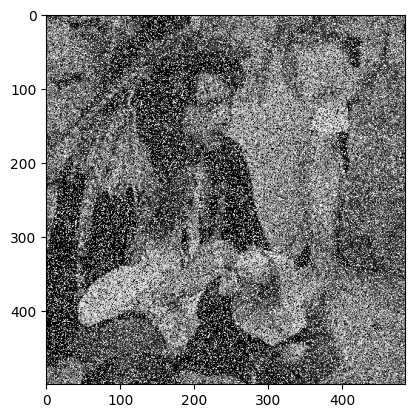

In [108]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)
m, n = image.shape  # 500, 485
num_rand = int(0.4 * m * n)

# salt-and-pepper noise
rand_generator = np.random.default_rng(seed=0)
all_indices = [i for i in range(m * n)]
random.shuffle(all_indices)
rand_indices = all_indices[: num_rand]  # indices to add noise
clean_indices = all_indices[num_rand: ]  # clean indices not add noise
image_noise = np.copy(image)
for i in rand_indices:
    image_noise.flat[i] = rand_generator.choice([0, 255])

plt.imshow(image, cmap='gray')
plt.imshow(image_noise, cmap='gray')
plt.show()

Epoch 0, relative_error: 0.86, PSNR: -44.63
Epoch 1, relative_error: 0.78, PSNR: -43.78
Epoch 2, relative_error: 0.72, PSNR: -43.14
Epoch 3, relative_error: 0.68, PSNR: -42.68
Epoch 4, relative_error: 0.66, PSNR: -42.35
Epoch 5, relative_error: 0.64, PSNR: -42.13
Epoch 6, relative_error: 0.63, PSNR: -41.98
Epoch 7, relative_error: 0.62, PSNR: -41.89
Epoch 8, relative_error: 0.62, PSNR: -41.82
Epoch 9, relative_error: 0.62, PSNR: -41.78
Epoch 10, relative_error: 0.62, PSNR: -41.75
Epoch 11, relative_error: 0.61, PSNR: -41.74
Epoch 12, relative_error: 0.61, PSNR: -41.73
Epoch 13, relative_error: 0.61, PSNR: -41.72
Epoch 14, relative_error: 0.61, PSNR: -41.72
Epoch 15, relative_error: 0.61, PSNR: -41.71
Epoch 16, relative_error: 0.61, PSNR: -41.71
Epoch 17, relative_error: 0.61, PSNR: -41.71
Epoch 18, relative_error: 0.61, PSNR: -41.71
Epoch 19, relative_error: 0.61, PSNR: -41.71
Epoch 20, relative_error: 0.61, PSNR: -41.71
Epoch 21, relative_error: 0.61, PSNR: -41.71
Epoch 22, relative_e

True

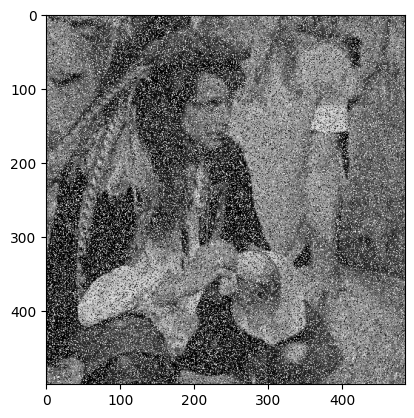

In [109]:
def POmega(matrix, clean_indices):
    """
    elements of 'clean_indices' kept unchanged, others set 0
    """
    a = np.zeros(matrix.shape)
    a.flat[clean_indices] = matrix.flat[clean_indices]
    return a

gamma1, gamma2 = 10, 30
def derivative(theta, gamma1=gamma1, gamma2=gamma2):
    """
    derivative of the penalty function
    """
    if theta <= gamma1:
        return 1
    elif theta <= gamma2:
        return (gamma2 - theta) / (gamma2 - gamma1)
    else:
        return 0

beta = 10
mu = 1 / beta
# X = np.copy(image_noise)
# X = np.zeros(image_noise.shape)
X = rand_generator.integers(0, 256, size=image_noise.shape)

for t in range(100):
    Ux, Sx, Vx = np.linalg.svd(X)  # (500, 500), (485,), (485, 485)
    w = np.array([derivative(i) for i in Sx])
    Y = X - 2 * POmega(X - image_noise, clean_indices) / beta
    Uy, Sy, Vy = np.linalg.svd(Y)  # (500, 500), (485,), (485, 485)
    
    # check SVD
    # print((np.linalg.multi_dot([Uy, np.pad(np.diag(Sy), pad_width=((0, 500 - 485), (0, 0))), Vy]) - Y) <= 1e-3)
    
    S = np.diag(Sy - mu * w)
    S[S < 0] = 0
    S = np.pad(S, pad_width=((0, 500 - 485), (0, 0)))
    X = np.linalg.multi_dot([Uy, S, Vy])

    relative_error = np.linalg.norm(X - image) / np.linalg.norm(image)
    psnr = 10 * np.log10(255 ** 2 / (np.linalg.norm(X - image) ** 2 / m * n))
    print(f"Epoch {t}, relative_error: {relative_error:.2f}, PSNR: {psnr:.2f}")
    if relative_error <= 1e-3:
        break

plt.imshow(X, cmap='gray')
cv2.imwrite('image_recover.jpg', X)

In [84]:
Uy, Sy, Vy = np.linalg.svd(Y)
S = np.pad(np.diag(Sy), pad_width=((0, 500 - 485), (0, 0)))
np.linalg.multi_dot([Uy, S, Vy.T]) == Y

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [97]:
A = np.array([[1, 2], [3, 4]])
U, S, V = np.linalg.svd(A)
(np.dot(U, np.dot(np.diag(S), V)) - A) <= 0.0001

array([[ True,  True],
       [ True,  True]])

In [103]:
A = np.array([[1, -2], [-3, 4]])
A[A < 0] = 0
A

array([[1, 0],
       [0, 4]])

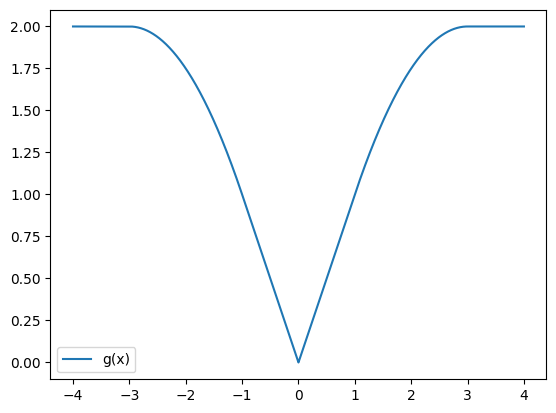

In [111]:
gamma1, gamma2 = 1, 3
def derivative(theta, gamma1=gamma1, gamma2=gamma2):
    """
    derivative of the penalty function
    """
    if theta <= gamma1:
        return 1
    elif theta <= gamma2:
        return (gamma2 - theta) / (gamma2 - gamma1)
    else:
        return 0
def penalty_func(theta, gamma1=gamma1, gamma2=gamma2):
    """
    Penalty Function
    theta: scalar, input variable
    """
    if abs(theta) <= gamma1:
        return abs(theta)
    elif abs(theta) <= gamma2:
        return (2 * gamma2 * abs(theta) - theta * theta - gamma1 * gamma1) \
        / (2 * (gamma2 - gamma1))
    else:
        return (gamma1 + gamma2) / 2

x = np.linspace(-4, 4, 100000)
y = [penalty_func(i, gamma1, gamma2) for i in x]
plt.plot(x, y, label='g(x)')
plt.legend()
plt.show()